In [1]:
# import pprint
# import sys

# pprint.pprint(sys.path)

In [2]:
# import fundamental libraries
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)

import os
import sys
sys.path.append('/mnt/c/Users/44yos/RacePrediction/resnet_win5')
from os import path
import time

# preporcessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from pickle import dump

# tesndorflow libraries
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import backend as K

# from models import resnet
from models import transformer

In [3]:
# load data
data = pd.read_csv("../data/csv/data.csv", sep = ",")
print(data.dtypes)

race_id                 int64
race_round              int64
ground_condition        int64
total_horse_number      int64
order                   int64
                       ...   
ground_type_芝_3       float64
ground_type_障_3       float64
horse_weight_dif_3    float64
same_jockey_3         float64
same_jockey           float64
Length: 150, dtype: object


In [4]:
# adjust columns type
data['race_id'] = data['race_id'].astype(str)
data['order'] = data['order'].astype(str)

In [5]:
# delete race day information
data = data.drop(["horse_number", "half_order", "goal_time" ,"last_time", "horse_weight", "horse_weight_dif", "frame_number","pop"], axis = 1)
# "race_round",

In [6]:
# standarlization 
no_scale_data = data[['race_id','order']]
scale_columns = data.drop(['race_id','order'], axis=1).columns.values
standard_scale = StandardScaler()
data = pd.DataFrame(standard_scale.fit_transform(data[scale_columns]))

# PCA
pca = PCA()
data = pd.DataFrame(pca.fit_transform(data))
contrb_rate = pd.DataFrame(pca.explained_variance_ratio_, columns = ['rate'])
sum_rate = 0

#  # to get the colum of the specific contribution rate
# for i in range(len(contrb_rate)):
#     sum_rate += contrb_rate.rate[i]
#     if sum_rate >= 0.9:
#         max_col = i + 1
#         break

max_col = 84
data = data.loc[:, :max_col-1]
# print(data.head(5))
data = pd.concat([data, no_scale_data], axis=1)
dump(standard_scale, open("standard_scale.pkl", "wb"))
dump(pca, open("pca.pkl", "wb"))

In [7]:
print(data.shape)
print(data.dtypes)
# print(data.head(20))

(92033, 86)
0          float64
1          float64
2          float64
3          float64
4          float64
            ...   
81         float64
82         float64
83         float64
race_id     object
order       object
Length: 86, dtype: object


In [8]:
def create_time_series_data(raw_data):
    number_of_race = raw_data.race_id.nunique()
    time_series_data = np.full((number_of_race, 18, max_col), 0.0)#-float('inf')
    label = np.full((number_of_race, 18), 19)
    race_number = 0
    horse_number = 0
    for i in range(len(raw_data)):
        if i == 0:
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
            continue
        # add new race
        if data.iloc[i].race_id != data.iloc[i-1].race_id:
            race_number += 1
            horse_number = 0
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
        # add new horse to the same race
        else:
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
    return time_series_data, label

In [9]:
X, y_order = create_time_series_data(data)
print(X.shape)
print(y_order.shape)

(8489, 18, 84)
(8489, 18)


In [10]:
X = X.astype('float32')
print(X.dtype)

float32


In [11]:
print(X[0][11])
print(y_order[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 5  2 11  7  1  6  3  8  4 12 14 19 19 19 19 19 19 19]


In [12]:
alpha = len(y_order) / pd.DataFrame(y_order.flatten()).value_counts()
alpha = alpha.sort_index()
alpha = np.array(alpha)
alpha = np.append(0,alpha)
print(alpha.shape)
print(alpha)

(20,)
[ 0.          1.22620251  1.21236789  1.23692263  1.24838235  1.27347735
  1.27233213  1.2771175   1.33202573  1.35824     1.42768248  1.52624955
  1.69170984  1.90080609  2.16445691  2.54619076  3.30697312 14.51111111
 19.42562929  0.13969294]


In [13]:
# creating X,y (parameters and target)
y = np_utils.to_categorical(y_order, dtype='float32')
print(y[0])
print(y.shape)
print(X.shape)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [14]:
def smooth_label(label, factor=0.03):
    # smooth label
    label *= (1 - factor)
    label[:,:,1:4] += (factor / 3)

    return label

In [15]:
y = smooth_label(y) 
print(y[0])
print(y.shape)
print(X.shape)

[[0.   0.01 0.01 0.01 0.   0.97 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.97 0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.   0.   0.   0.97 0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.98 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.   0.   0.97 0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.   0.   0.   0.   0.97 0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.97 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.97 0.
  0

AxesSubplot(0.125,0.125;0.775x0.755)


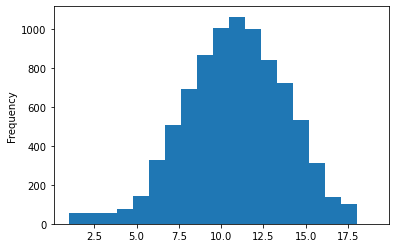

In [16]:
print(data.race_id.value_counts().plot.hist(bins=19,range=(1,19)))

AxesSubplot(0.125,0.125;0.775x0.755)


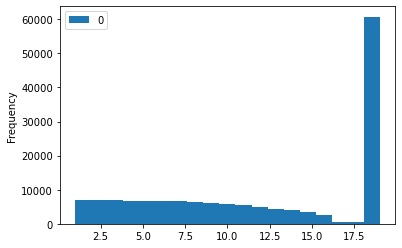

In [17]:
print(pd.DataFrame(y_order.flatten()).plot.hist(bins=19))## ,ylim=(0,1000)

In [18]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [19]:
print(X_train[0][1])

[-1.9299262   4.134452   -1.1845886  -2.021465    0.25058523  0.82196397
 -2.188934    1.2591479   2.8617375   1.4415435  -4.525045   -0.28279674
 -0.7045482  -1.2348168  -0.7875165   0.92294943  0.85601807 -0.18807171
  0.6115057   0.45147386  1.4542701   1.1123375   0.8362466  -0.06143021
  0.04694831 -0.38879588  0.61631036 -1.4220315   0.7546406  -0.22976409
 -0.44492173 -0.01354477  0.38679612  0.33232775  0.5791362  -0.5640976
  0.13934945 -0.21279134  0.35113946 -1.037108    0.43908733  0.36383373
  0.5892356   1.1468668  -0.6446959  -0.84666556 -1.0866684   0.7535178
  0.97460616  0.98329556  0.72370255 -1.2953513   0.18575504  0.00571653
  0.78280187 -0.07378098  0.06463592 -0.682534   -1.4659165  -1.294394
  0.46420598  0.18880065 -0.9035544   0.40041184 -0.2742774  -0.32797852
 -0.21715021 -0.7834587  -1.3757527  -0.10963269  0.09277364 -0.25345138
 -0.33370352  0.11308183  0.10243607 -1.0474299   0.3851259   0.61488616
 -0.56743914  0.67876774  0.10173528 -0.4947941  -0.339

In [20]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6791, 18, 84)
(1698, 18, 84)
(6791, 18, 20)
(1698, 18, 20)


In [21]:
def categorical_focal_loss(alpha, gamma):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [22]:
# creating dataset with batch size
batch_size = 1024 # hyperparameter
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=6791).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size=1698).batch(batch_size)

In [23]:
# set up parameters
num_layers = 1 # hyperparameter
d_model = max_col # 4*35 84=4*21
num_heads = 21 # hyperparameter *must be a factor of d_model*
d_ffn = 8 # hyperparameter
pe_input = 18
target_size = 20
dropout_rate = 0.1 # hyperparameter

In [24]:
# set up model
trans_race = transformer.TransRace(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ffn=d_ffn,
    pe_input=pe_input,
    target_size=target_size,
    rate=dropout_rate,
)
opt = optimizers.Adam(decay=0.01)
loss = categorical_focal_loss(alpha=[alpha], gamma=0.5)
trans_race.compile(
    optimizer=opt,
    loss=loss,#'categorical_crossentropy', # 'sigmoid_focal_crossentropy'
    metrics=['accuracy'], #['categorical_accuracy']
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
history = trans_race.fit(
                        train_dataset,
                        validation_data=valid_dataset,
                        epochs=10,
                        verbose=True, # hide the output because we have so many epochs
                        )
print(trans_race.summary())
trans_race.save_weights("../models/results/transformer5.h5")

# the problem is gradient exploding

mask shape after creating (?, 1, 1, 18)
mask shape after creating (?, 1, 1, 18)
(?, 18, 84) mha
(?, 18, 21, 4) split_head
(?, 18, 21, 4) split_head
(?, 18, 21, 4) split_head
(?, 21, 18, 4) q_shape
(?, 21, 18, 18) scaled_attention_shape
(?, 1, 1, 18) mask shape
final output shape (?, 18, 20)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7 steps, validate on 2 steps
Epoch 1/10
7/7 [==============================] - 5s 727ms/step - loss: 3.7200 - acc: 0.0624 - val_loss: 3.4978 - val_acc: 0.1151
Epoch 2/10
7/7 [==============================] - 0s 56ms/step - loss: 3.4702 - acc: 0.1232 - val_loss: 3.3262 - val_acc: 0.2159
Epoch 3/10
7/7 [==============================] - 0s 57ms/step - loss: 3.3068 - acc: 0.2015 - val_loss: 3.1941 - val_acc: 0.3015
Epoch 4/10
7/7 [==============================] - 0s 57ms/step - loss: 3.1903 - acc: 0.2720 - val_loss: 3.1117 - val_acc: 0.3480
Epoch 5/10
7/7 [==============================] - 0s 57ms/s

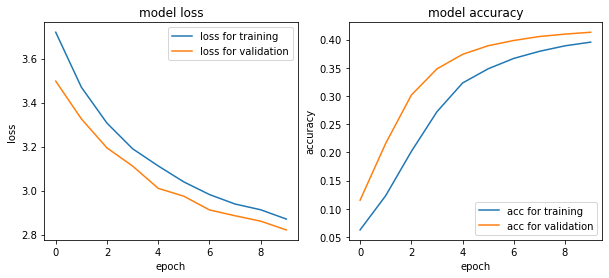

In [26]:
# plot 
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# for loss
axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
axR.plot(history.history['acc'],label="acc for training")
axR.plot(history.history['val_acc'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='lower right')
# figureの保存
# plt.savefig("../models/results/trans_race_result.png")

In [28]:
# predict

pred = trans_race.predict(X_valid)
y_pred = np.argmax(pred, axis = 2)
y_ans = np.argmax(y_valid, axis = 2)


In [29]:
print(pred.shape)
print(y_pred.shape)
print(y_ans.shape)


(1698, 18, 20)
(1698, 18)
(1698, 18)


In [30]:
print(y_ans[0])
print(y_pred[1])
# print(np.mean(y_pred))

[ 8 10  9  3  4  7  5  6  1  2 19 19 19 19 19 19 19 19]
[ 7 10  3  2 13  2 14 16  9  5  9  4  4  4 19 19 19 19]


In [31]:
correct = 0
for i in range(len(y_pred)):
    for j in range(len(y_pred[0])):
        if (y_pred[i][j] == y_ans[i][j]):
            correct += 1
accuracy = correct / len(y_pred)
print("accuracy: ", accuracy)

accuracy:  7.432273262661956


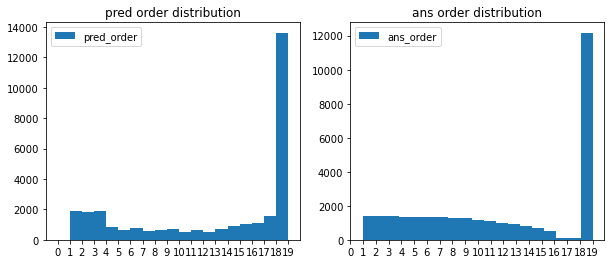

In [32]:
# the distribution of prediction
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
label = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']

axL.hist(y_pred.flatten(), bins = 19, label = "pred_order")##, range = (1,21)
axL.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
axL.set_xticklabels(label)
axL.set_title('pred order distribution')
axL.legend()
axR.hist(y_ans.flatten(), bins = 19, label = "ans_order")##, range = (1,21)
axR.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
axR.set_xticklabels(label)
axR.set_title('ans order distribution')
axR.legend()
fig.show()


In [34]:
# precision = TP / (TP + FP)
# the accuracy of predected True
i = 0
correct_first = 0
all_f = 0
increase = 0
X_valid_inv = standard_scale.inverse_transform(X_valid)
X_valid_inv_df = pd.DataFrame(X_valid_inv)
odds = X_test_inv_df['odds'].values
hit_odds = []
select = []

for i in range(len(Y_ans)):
    if (pred_order[i] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
        all_f = all_f + 1
        if (Y_ans[i] == 1):
            correct_first = correct_first + 1   #　True Positive
            increase += odds[i]
            hit_odds.append(odds[i])
            
            
            
print("all_f: ", all_f)
print("correct_first: ", correct_first)
print("hit odds average: ", np.array(hit_odds).mean())
print("spent money:", all_f * 100)
revenue = (increase - all_f) * 100
retrive = increase / all_f
 
print("retrive rate: ", retrive) 
print("revenue: ", revenue)
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
#print("\n".join(map(str,hit_odds)))
print("min: ", min(hit_odds))
print("mid: ", np.median(np.array(hit_odds)))
print("max: ", max(hit_odds))

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.hist(hit_odds, bins = 50, label = "hit_odds")
axL.set_title('hit odds distribution')
axL.legend()
axR.hist(odds, bins = 50, label = "odds", range = (0,40))
axR.set_title('all odds distribution')
axR.legend()
fig.show()


ValueError: operands could not be broadcast together with shapes (1698,18,84) (140,) (1698,18,84) 

In [ ]:
# Recall = TP / (TP + FN)
# the accuracy of label True
i = 0
correct_first = 0
all_f = 0
odds_f = []
p_rate_f = []

all_f_odds = []

for i in range(len(Y_ans)):
    if (Y_ans[i] == 1):  # TP + FN
        all_f = all_f + 1
        all_f_odds.append(odds[i])
        if (pred_order[i] == 1):
            correct_first = correct_first + 1   #　TP
            odds_f.append(odds[i])
            p_rate_f.append(pred[i][1])

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.scatter(p_rate_f, odds_f)  
axL.set_title('correlation odss and prediction')
#axL.xlabel('prediction rate first')
#axL.ylabel('odds')
axR.hist(odds_f, bins = 50, label = "odds")
axR.set_title('all first odds distribution')
axR.legend()

fig.show()
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
print("all_f_odds average: ", np.array(all_f_odds).mean())

